In [1]:
import pandas as pd
import numpy as np
import pyprind 
import nltk
from nltk.stem import WordNetLemmatizer
import re
from nltk.corpus import stopwords
import time
from time import sleep

In [2]:
df = pd.read_csv('moview_reviews.txt', encoding='utf-8')
df.head(3)

,review,sentiment
0,"Some ugly weirdo who had three families, cheat...",0
1,I watched this movie once and might watch it a...,1
2,Classe Tous Risques (The Big Risk) is repeated...,1


In [22]:
#df.to_csv('moview_reviews.csv',index=False,encoding='utf-8')

<AxesSubplot:>

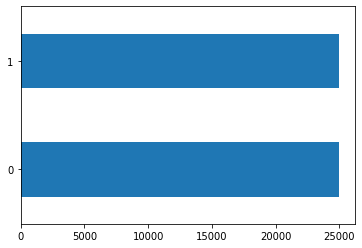

In [21]:
df.sentiment.value_counts().plot(kind='barh')

In [3]:
lemmatizer = WordNetLemmatizer()

In [4]:
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',text)
    #print(emoticons)
    text = (re.sub('[\W]+', ' ', text.lower()) +' '.join(emoticons).replace('-', ''))
    return text

In [5]:
def tokenizer(text):
    return text.split()

In [6]:
def tokenizer_lemmatize(text):
    return [lemmatizer.lemmatize(word) for word in text.split()]

In [7]:
nltk.download('stopwords') # stop word removal
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Training a logistic regression model for document classification

In [8]:
X_train = df.loc[:25000, 'review'].values
y_train = df.loc[:25000, 'sentiment'].values
X_test = df.loc[25000:, 'review'].values
y_test = df.loc[25000:, 'sentiment'].values

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

In [10]:
tfidf = TfidfVectorizer(strip_accents=None,lowercase=False,preprocessor=None)

In [11]:
param_grid = [{'vect__ngram_range': [(1,1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer,tokenizer_lemmatize],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [10.0, 0.10, 0.01]},
              {'vect__ngram_range': [(1,1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer,tokenizer_lemmatize],
               'vect__use_idf':[False],'vect__norm':[None],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 0.10, 0.01]}
             ]


In [12]:
lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf',LogisticRegression(random_state=0))])

In [13]:
gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='accuracy',
                           cv=5, verbose=1,
                           n_jobs=-1)
t = time.time()
gs_lr_tfidf.fit(X_train, y_train)
# do stuff
print('Elapsed: {} %s'.format(time.time() - t))

Fitting 5 folds for each of 48 candidates, totalling 240 fits


C:\Anaconda3\envs\AML\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan 0.88740453 0.88624458
 0.88956443 0.8890445         nan        nan        nan        nan
 0.84608613 0.84208633 0.82804709 0.82692714        nan        nan
        nan        nan 0.80712774 0.79564822 0.77312942 0.77384943
        nan        nan        nan        nan 0.87588498 0.8758049
 0.87728494 0.87856501        nan        nan        nan        nan
 0.87876477 0.87816494 0.8814048  0.8809649         nan        nan
        nan        nan 0.86844541 0.86668549 0.86680553 0.86764537]
  category=UserWarning


Elapsed: 1664.0983254909515 %s


C:\Anaconda3\envs\AML\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [14]:
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)

Best parameter set: {'clf__C': 10.0, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 1), 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer at 0x0000014B0313CF78>} 


In [15]:
LogisticRegression(random_state=0)

LogisticRegression(random_state=0)

In [16]:
print('CV Accuracy: %.3f'% gs_lr_tfidf.best_score_)

CV Accuracy: 0.890


In [17]:
clf = gs_lr_tfidf.best_estimator_
print('Test Accuracy: %.3f'% clf.score(X_test, y_test))

Test Accuracy: 0.891


The results reveal that our machine learning model can predict whether a movie
review is positive or negative with ~90 percent accuracy.